In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL 
import PIL.Image
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras import Sequential
from keras.engine import  Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from skimage.transform import resize
from keras.regularizers import l2
import random

Mount google drive to colab

In [ ]:
# Check is Link to Drive is OK
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


Dictionary introducing emotions

In [ ]:
emotions={0:'Anger',1:'Disgust',2:'Fear',3:'Happiness',4:'Sadness',5:'Surprise',6:'Neutral'}

In [ ]:
file_path="/content/GDrive/My Drive/FER-images/fer2013.csv"

In [ ]:
data=pd.read_csv(file_path)

In [ ]:
data_train=data.loc[data['Usage']=='Training']
public_test=data.loc[data['Usage']=='PublicTest']
private_test=data.loc[data['Usage']=='PrivateTest']

In [ ]:
from sklearn.utils import shuffle
data_train=shuffle(data_train)
public_test=shuffle(public_test)
private_test=shuffle(private_test)

In [ ]:
data_train.head()

,emotion,pixels,Usage
24058,3,113 111 128 117 85 57 61 41 53 73 62 27 23 34 ...,Training
18369,0,244 244 247 210 121 119 137 154 167 182 180 17...,Training
14556,4,70 69 62 62 67 54 36 32 45 50 46 50 54 55 54 4...,Training
19150,3,102 2 16 15 27 42 99 163 181 187 192 195 191 1...,Training
13202,5,146 195 192 169 150 162 168 210 220 210 217 15...,Training


Reading Train/Dev/Test sets and randomly add some horizontally flipped training inputs. 

In [ ]:
def data_augmentation(img_data):
    img_data = cv2.flip(img_data.reshape(48,48), 1)
    return np.array(img_data.reshape(48,48,1)).astype(np.uint8)

In [ ]:
def change_aug_data(dataset):
  train_data_flipped=list()
  train_y_flipped=list()
  for i in range(0,dataset.shape[0]):
    img_str=dataset.iloc[i]['pixels'].split(' ')
    img_data=np.array(img_str,dtype=np.uint8).reshape(48,48)
    img_flipped=data_augmentation(img_data)
    train_data_flipped.append(cv2.cvtColor(img_flipped,cv2.COLOR_GRAY2BGR))
    train_y_flipped.append(dataset.iloc[i]['emotion'])
  return train_data_flipped,train_y_flipped

def change_data(dataset):
  final_data=list()  
  for i in range(0,dataset.shape[0]):
    img_str=dataset.iloc[i]['pixels'].split(' ')
    img_data=np.array(img_str,dtype=np.uint8).reshape(48,48)
    img_final=cv2.cvtColor(img_data,cv2.COLOR_GRAY2BGR)
    final_data.append(img_final)
  return final_data
data_train_flipped,data_y_flipped=change_aug_data(data_train)
pairs = list(zip(data_train_flipped, data_y_flipped))  # make pairs out of the two lists
pairs = random.sample(pairs, 10000)  # pick 3 random pairs
data_train_flipped_reduced,data_y_flipped_reduced = zip(*pairs)  # separate the pairs
#fer_x_train=np.array(change_data(data_train))
fer_x_train=np.array(change_data(data_train) + list(data_train_flipped_reduced))    
fer_x_test=np.array(change_data(private_test))
fer_x_valid=np.array(change_data(public_test))

In [ ]:
np.array(data_y_flipped_reduced).shape
print(np.array(data_y_flipped_reduced))

[2 3 6 ... 6 4 6]


In [ ]:
print(fer_x_train.shape)
print(fer_x_test.shape)
print(fer_x_valid.shape)

(38709, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


Happiness


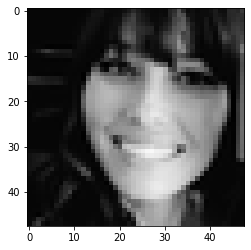

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((np.array(data_train_flipped_reduced)[20]))
print(emotions[np.array(data_y_flipped_reduced)[20]])

Normalizing images by dividing by 255

In [ ]:
fer_x_train = fer_x_train/255
fer_x_test = fer_x_test/255
fer_x_valid = fer_x_valid/255

In [ ]:
#fer_y_train=np.array(data_train['emotion'])
fer_y_train=np.concatenate((np.array(data_train['emotion']),np.array(data_y_flipped_reduced)),axis=0)
fer_y_test=np.array(private_test['emotion'])
fer_y_valid=np.array(public_test['emotion'])

In [ ]:
fer_y_train.shape

(38709,)

Surprise


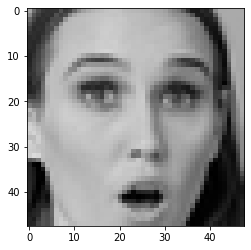

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(fer_x_train[37706])
print(emotions[fer_y_train[37706]])

Onehot Encoding

In [ ]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [ ]:
fer_y_train = onehot(fer_y_train, 7).T
fer_y_test = onehot(fer_y_test, 7).T
fer_y_valid = onehot(fer_y_valid, 7).T

In [ ]:
fer_y_train.shape

(38709, 7)

Shuffing train set

In [ ]:
#from random import shuffle
fer_x_train, fer_y_train = shuffle(fer_x_train, fer_y_train, random_state=2)

Defining VGG16 model for transfer learning. First 11 layers are freezed and the paramters in the next layers will be changed due to fine tuning. 

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(48,48,3))
layer=Flatten()(vgg.output)
layer=Dense(512,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(256,activation='relu')(layer)
layer=Dropout(0.2)(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dense(64,activation='relu')(layer)

for i in range(11):
    vgg.layers[i].trainable = False

pred=Dense(7,activation='softmax')(layer)

print(vgg.get_layer('block4_conv1').trainable)
vgg_model = Model(inputs=vgg.input, outputs=pred)

True


In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [ ]:
vgg_model.compile(loss='categorical_crossentropy',optimizer=Adamax(),metrics=['accuracy']) #Adamax()

FER-2013 check 

In [ ]:
vgg_model.load_weights('/content/GDrive/My Drive/vgg_freeze_animated_model_weights.h5')

In [ ]:
history=vgg_model.fit(fer_x_train,fer_y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(fer_x_valid, fer_y_valid),
          shuffle=True)

Epoch 1/100
303/303 [==============================] - 20s 63ms/step - loss: 1.7292 - accuracy: 0.2888 - val_loss: 1.4164 - val_accuracy: 0.4639
Epoch 2/100
303/303 [==============================] - 19s 63ms/step - loss: 1.3422 - accuracy: 0.4757 - val_loss: 1.2397 - val_accuracy: 0.5266
Epoch 3/100
303/303 [==============================] - 19s 63ms/step - loss: 1.2160 - accuracy: 0.5362 - val_loss: 1.1720 - val_accuracy: 0.5534
Epoch 4/100
303/303 [==============================] - 19s 62ms/step - loss: 1.0861 - accuracy: 0.5930 - val_loss: 1.1598 - val_accuracy: 0.5659
Epoch 5/100
303/303 [==============================] - 19s 63ms/step - loss: 0.9729 - accuracy: 0.6407 - val_loss: 1.1236 - val_accuracy: 0.5840
Epoch 6/100
303/303 [==============================] - 19s 63ms/step - loss: 0.8505 - accuracy: 0.6876 - val_loss: 1.1376 - val_accuracy: 0.5988
Epoch 7/100
303/303 [==============================] - 19s 63ms/step - loss: 0.7188 - accuracy: 0.7445 - val_loss: 1.1208 - val_ac

In [ ]:
vgg_model.evaluate(fer_x_test, fer_y_test)

113/113 [==============================] - 1s 12ms/step - loss: 2.4865 - accuracy: 0.6475


[2.4865269660949707, 0.6475341320037842]

In [ ]:
vgg_model.save('/content/GDrive/My Drive/FER_aug_vgg16_freeze.h5')

In [ ]:
vgg_model.save_weights('/content/GDrive/My Drive/FER_vgg16_freeze_weights.h5')

Animated_images

In [ ]:
animate_emotions={0:'anger',1:'disgust',2:'fear',3:'joy',4:'sadness',5:'surprise',6:'neutral'}

In [ ]:
! rm -rf animated_images; mkdir animated_images
! unzip -q '/content/GDrive/My Drive/FER-images/all_animated_images.zip' -d animated_images

Pandas dateframes for keeping information of the animated images.

In [ ]:
anger_df = pd.DataFrame()
origin_folder='/content/animated_images/anger' #animated
files=os.listdir(origin_folder) 
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
anger_df['file']=image_files
anger_df['file_name']=files
anger_df['label']=0
anger_df.head()

,file,file_name,label
0,/content/animated_images/anger/anger-020799.png,anger-020799.png,0
1,/content/animated_images/anger/anger-021940.png,anger-021940.png,0
2,/content/animated_images/anger/anger-022029.png,anger-022029.png,0
3,/content/animated_images/anger/anger-019044.png,anger-019044.png,0
4,/content/animated_images/anger/anger-021516.png,anger-021516.png,0


In [ ]:
disgust_df = pd.DataFrame()
origin_folder='/content/animated_images/disgust'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
disgust_df['file']=image_files
disgust_df['file_name']=files
disgust_df['label']=1
disgust_df.head()

,file,file_name,label
0,/content/animated_images/disgust/disgust-00722...,disgust-007222.png,1
1,/content/animated_images/disgust/disgust-00766...,disgust-007660.png,1
2,/content/animated_images/disgust/disgust-00337...,disgust-003374.png,1
3,/content/animated_images/disgust/disgust-00460...,disgust-004607.png,1
4,/content/animated_images/disgust/disgust-00788...,disgust-007889.png,1


In [ ]:
fear_df = pd.DataFrame()
origin_folder='/content/animated_images/fear'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
fear_df['file']=image_files
fear_df['file_name']=files
fear_df['label']=2
fear_df.head()

,file,file_name,label
0,/content/animated_images/fear/fear-055189.png,fear-055189.png,2
1,/content/animated_images/fear/fear-054197.png,fear-054197.png,2
2,/content/animated_images/fear/fear-051427.png,fear-051427.png,2
3,/content/animated_images/fear/fear-050109.png,fear-050109.png,2
4,/content/animated_images/fear/fear-055698.png,fear-055698.png,2


In [ ]:
joy_df = pd.DataFrame()
origin_folder='/content/animated_images/joy'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
joy_df['file']=image_files
joy_df['file_name']=files
joy_df['label']=3
joy_df.head()

,file,file_name,label
0,/content/animated_images/joy/joy-042119.png,joy-042119.png,3
1,/content/animated_images/joy/joy-042243.png,joy-042243.png,3
2,/content/animated_images/joy/joy-045693.png,joy-045693.png,3
3,/content/animated_images/joy/joy-044430.png,joy-044430.png,3
4,/content/animated_images/joy/joy-046679.png,joy-046679.png,3


In [ ]:
sadness_df = pd.DataFrame()
origin_folder='/content/animated_images/sadness'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
sadness_df['file']=image_files
sadness_df['file_name']=files
sadness_df['label']=4
sadness_df.head()

,file,file_name,label
0,/content/animated_images/sadness/sadness-03584...,sadness-035843.png,4
1,/content/animated_images/sadness/sadness-03570...,sadness-035707.png,4
2,/content/animated_images/sadness/sadness-03562...,sadness-035620.png,4
3,/content/animated_images/sadness/sadness-03459...,sadness-034595.png,4
4,/content/animated_images/sadness/sadness-03518...,sadness-035183.png,4


In [ ]:
surprise_df = pd.DataFrame()
origin_folder='/content/animated_images/surprise'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
surprise_df['file']=image_files
surprise_df['file_name']=files
surprise_df['label']=5
surprise_df.head()

,file,file_name,label
0,/content/animated_images/surprise/surprise-028...,surprise-028467.png,5
1,/content/animated_images/surprise/surprise-030...,surprise-030971.png,5
2,/content/animated_images/surprise/surprise-030...,surprise-030646.png,5
3,/content/animated_images/surprise/surprise-032...,surprise-032901.png,5
4,/content/animated_images/surprise/surprise-025...,surprise-025738.png,5


In [ ]:
neutral_df = pd.DataFrame()
origin_folder='/content/animated_images/neutral'
files=os.listdir(origin_folder)
image_files=[]
for i in range(len(files)):
  file_addr=origin_folder+'/'+files[i]
  image_files.append(file_addr)
neutral_df['file']=image_files
neutral_df['file_name']=files
neutral_df['label']=6
neutral_df.head()

,file,file_name,label
0,/content/animated_images/neutral/neutral-00864...,neutral-008640.png,6
1,/content/animated_images/neutral/neutral-01303...,neutral-013037.png,6
2,/content/animated_images/neutral/neutral-01324...,neutral-013244.png,6
3,/content/animated_images/neutral/neutral-01104...,neutral-011047.png,6
4,/content/animated_images/neutral/neutral-01432...,neutral-014326.png,6


Concatenate all dataframes together.

In [ ]:
#frames=[anger_df_reduced,disgust_df_reduced,fear_df_reduced,joy_df_reduced,sadness_df_reduced,surprise_df_reduced,neutral_df_reduced]
frames=[anger_df,disgust_df,fear_df,joy_df,sadness_df,surprise_df,neutral_df]
total_df=pd.concat(frames)
total_df.head(200)
print(total_df.shape[1])
total_df.head()

3


,file,file_name,label
0,/content/animated_images/anger/anger-020799.png,anger-020799.png,0
1,/content/animated_images/anger/anger-021940.png,anger-021940.png,0
2,/content/animated_images/anger/anger-022029.png,anger-022029.png,0
3,/content/animated_images/anger/anger-019044.png,anger-019044.png,0
4,/content/animated_images/anger/anger-021516.png,anger-021516.png,0


Train/Test split

In [ ]:
df_x_train,df_x_test,df_y_train,df_y_test=train_test_split(total_df,total_df['label'],test_size=0.2)

In [ ]:
df_x_train.shape

(44612, 3)

In [ ]:
df_x_test.shape

(11154, 3)

In [ ]:
df_x_train.head(20)

,file,file_name,label
1189,/content/processed_images/joy/image_5360.png,image_5360.png,3
1167,/content/processed_images/joy/image_5365.png,image_5365.png,3
1217,/content/processed_images/disgust/image_2975.png,image_2975.png,1
360,/content/processed_images/neutral/image_9997.png,image_9997.png,6
543,/content/processed_images/anger/image_785.png,image_785.png,0
576,/content/processed_images/disgust/image_1892.png,image_1892.png,1
789,/content/processed_images/sadness/image_7041.png,image_7041.png,4
1390,/content/processed_images/anger/image_1048.png,image_1048.png,0
1471,/content/processed_images/disgust/image_2684.png,image_2684.png,1
1066,/content/processed_images/surprise/image_8783.png,image_8783.png,5


In [ ]:
!rm -rf animated_train animated_test
!mkdir animated_train
!mkdir animated_test

In [ ]:
!mkdir animated_train/anger animated_train/disgust animated_train/fear animated_train/joy animated_train/sadness animated_train/surprise animated_train/neutral

In [ ]:
!mkdir animated_test/anger animated_test/disgust animated_test/fear animated_test/joy animated_test/sadness animated_test/surprise animated_test/neutral

Haar cascade classifier for face detection.

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/GDrive/My Drive/FER-images/Haar/haarcascade_frontalface_default.xml')

Pre-processing images 

In [ ]:
for index,row in df_x_train.iterrows():
  img=cv2.imread(row['file'])
  img=img.astype(np.uint8)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray,1.3,5)
  for (x,y,w,h) in faces:
    face_crop=gray[y:y+h,x:x+w]
    resized=cv2.resize(face_crop,(48,48),interpolation=cv2.INTER_LINEAR)   
    cv2.imwrite('/content/animated_train/'+animate_emotions[row['label']]+'/'+row['file_name'],resized)

In [ ]:
for index,row in df_x_test.iterrows():
  img=cv2.imread(row['file'])
  img=img.astype(np.uint8)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray,1.3,5)
  for (x,y,w,h) in faces:
    face_crop=gray[y:y+h,x:x+w]
    resized=cv2.resize(face_crop,(48,48),interpolation=cv2.INTER_LINEAR)   
    cv2.imwrite('/content/animated_test/'+animate_emotions[row['label']]+'/'+row['file_name'],resized)

In [ ]:
!ls -1 animated_train/* | wc -l
!ls -1 animated_train/anger | wc -l
!ls -1 animated_train/disgust | wc -l
!ls -1 animated_train/fear | wc -l
!ls -1 animated_train/joy | wc -l
!ls -1 animated_train/sadness | wc -l
!ls -1 animated_train/surprise | wc -l
!ls -1 animated_train/neutral | wc -l

34605
6662
6678
1591
5188
5147
4344
4982


In [ ]:
!ls -1 animated_test/* | wc -l
!ls -1 animated_test/anger | wc -l
!ls -1 animated_test/disgust | wc -l
!ls -1 animated_test/fear | wc -l
!ls -1 animated_test/joy | wc -l
!ls -1 animated_test/sadness | wc -l
!ls -1 animated_test/surprise | wc -l
!ls -1 animated_test/neutral | wc -l

8674
1657
1676
390
1369
1309
1049
1211


In [ ]:
# %%bash

# (for dir in animated_test
#     #do rm -rf $dir/*.zip
#     do pushd $dir && zip -r $dir.zip * && popd
#  done)

In [ ]:
# ! mv animated_test/animated_test.zip '/content'

In [ ]:
# ! cp animated_test.zip '/content/GDrive/My Drive/FER-images/animated_processed_images'

In [ ]:
# !rm -rf animated_images

Image-data generator for reading images.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BS=32
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            validation_split=0.2)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen  

In [ ]:
train_datagen=get_datagen('/content/animated_train',True)

train_generator=train_datagen.flow_from_directory(
            '/content/animated_train',
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS,
            subset='training')
dev_generator=train_datagen.flow_from_directory(
            '/content/animated_train',
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS,
            subset='validation')
test_datagen=get_datagen('/content/animated_test',False)
test_generator=test_datagen.flow_from_directory(
            '/content/animated_test',
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

Found 27677 images belonging to 7 classes.
Found 6915 images belonging to 7 classes.
Found 8661 images belonging to 7 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32, 7)


VGG model training on animated models

In [ ]:
my_history=vgg_model.fit(train_generator,
          steps_per_epoch=train_generator.samples// BS,
          epochs=20,
          validation_data=dev_generator,
          validation_steps=dev_generator.samples // BS)

Epoch 1/20
864/864 [==============================] - 52s 51ms/step - loss: 0.9997 - accuracy: 0.5850 - val_loss: 0.2604 - val_accuracy: 0.9171
Epoch 2/20
864/864 [==============================] - 43s 49ms/step - loss: 0.0511 - accuracy: 0.9868 - val_loss: 0.2722 - val_accuracy: 0.9489
Epoch 3/20
864/864 [==============================] - 43s 49ms/step - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.2552 - val_accuracy: 0.9369
Epoch 4/20
864/864 [==============================] - 43s 49ms/step - loss: 0.0134 - accuracy: 0.9968 - val_loss: 0.3295 - val_accuracy: 0.9303
Epoch 5/20
864/864 [==============================] - 42s 49ms/step - loss: 0.0103 - accuracy: 0.9979 - val_loss: 0.1945 - val_accuracy: 0.9599
Epoch 6/20
864/864 [==============================] - 43s 49ms/step - loss: 0.0129 - accuracy: 0.9973 - val_loss: 0.2026 - val_accuracy: 0.9549
Epoch 7/20
864/864 [==============================] - 42s 49ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.2938 - val_accuracy:

In [ ]:
vgg_model.evaluate(test_generator)

271/271 [==============================] - 4s 13ms/step - loss: 0.1037 - accuracy: 0.9873


[0.10365729033946991, 0.987299382686615]

In [ ]:
vgg_model.save_weights('/content/GDrive/My Drive/vgg_freeze_animated_model_weights.h5')

In [ ]:
vgg_model.save('/content/GDrive/My Drive/vgg_freeze_animated_model.h5')

CNN classifier

In [ ]:
my_model=Sequential()
my_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(48,48,3),kernel_regularizer=l2(0.01)))
my_model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D((2,2),strides=(2,2)))
my_model.add(Dropout(0.25))
my_model.add(Conv2D(128,(3,3),activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D((2,2),strides=(2,2)))
my_model.add(Dropout(0.35))
my_model.add(Conv2D(256,(3,3),activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D((2,2),strides=(2,2)))
my_model.add(Dropout(0.5))
my_model.add(Flatten())
my_model.add(Dense(1024,activation='relu')) 
my_model.add(Dropout(0.5))
my_model.add(Dense(512,activation='relu')) 
my_model.add(Dropout(0.25))
my_model.add(Dense(256,activation='relu')) 
my_model.add(Dropout(0.25))
my_model.add(Dense(64,activation='relu')) 
my_model.add(Dense(7,activation='softmax'))

In [ ]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 21, 21, 128)      

In [ ]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
my_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

CNN model training on animated data.

In [ ]:
my_history1=my_model.fit(train_generator,
          steps_per_epoch=train_generator.samples// BS,
          epochs=20,
          validation_data=dev_generator,
          validation_steps=dev_generator.samples // BS)

Epoch 1/20
864/864 [==============================] - 40s 45ms/step - loss: 1.7407 - accuracy: 0.3661 - val_loss: 1.3585 - val_accuracy: 0.5618
Epoch 2/20
864/864 [==============================] - 38s 44ms/step - loss: 0.2652 - accuracy: 0.9272 - val_loss: 1.3670 - val_accuracy: 0.7004
Epoch 3/20
864/864 [==============================] - 38s 44ms/step - loss: 0.1336 - accuracy: 0.9671 - val_loss: 0.4940 - val_accuracy: 0.8756
Epoch 4/20
864/864 [==============================] - 38s 44ms/step - loss: 0.0940 - accuracy: 0.9790 - val_loss: 0.9166 - val_accuracy: 0.7872
Epoch 5/20
864/864 [==============================] - 38s 44ms/step - loss: 0.0738 - accuracy: 0.9851 - val_loss: 0.5184 - val_accuracy: 0.8791
Epoch 6/20
864/864 [==============================] - 38s 44ms/step - loss: 0.0692 - accuracy: 0.9866 - val_loss: 0.3425 - val_accuracy: 0.9210
Epoch 7/20
864/864 [==============================] - 38s 44ms/step - loss: 0.0548 - accuracy: 0.9903 - val_loss: 0.5678 - val_accuracy:

In [ ]:
my_model.evaluate(test_generator)

271/271 [==============================] - 3s 11ms/step - loss: 0.0561 - accuracy: 0.9936


[0.05607219785451889, 0.9936497211456299]

In [ ]:
my_model.save('/content/GDrive/My Drive/my_animated_model.h5')

In [ ]:
my_model.save_weights('/content/GDrive/My Drive/my_animated_model_weights.h5')

CNN model training on FER dataset

In [ ]:
history1=my_model.fit(fer_x_train,fer_y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(fer_x_valid, fer_y_valid))

Epoch 1/100
303/303 [==============================] - 18s 56ms/step - loss: 2.0263 - accuracy: 0.2189 - val_loss: 1.8232 - val_accuracy: 0.2527
Epoch 2/100
303/303 [==============================] - 17s 56ms/step - loss: 1.7068 - accuracy: 0.3292 - val_loss: 1.5693 - val_accuracy: 0.3678
Epoch 3/100
303/303 [==============================] - 17s 55ms/step - loss: 1.4788 - accuracy: 0.4159 - val_loss: 1.4951 - val_accuracy: 0.4232
Epoch 4/100
303/303 [==============================] - 16s 54ms/step - loss: 1.3491 - accuracy: 0.4784 - val_loss: 1.5384 - val_accuracy: 0.4366
Epoch 5/100
303/303 [==============================] - 16s 54ms/step - loss: 1.2439 - accuracy: 0.5249 - val_loss: 1.2214 - val_accuracy: 0.5411
Epoch 6/100
303/303 [==============================] - 16s 54ms/step - loss: 1.1795 - accuracy: 0.5529 - val_loss: 1.1999 - val_accuracy: 0.5500
Epoch 7/100
303/303 [==============================] - 16s 54ms/step - loss: 1.1352 - accuracy: 0.5688 - val_loss: 1.1746 - val_ac

In [ ]:
my_model.evaluate(fer_x_test,fer_y_test)

113/113 [==============================] - 1s 6ms/step - loss: 1.4544 - accuracy: 0.6659


[1.4544098377227783, 0.6659236550331116]

In [ ]:
my_model.save('/content/GDrive/My Drive/FER_aug_my_model.h5')

In [ ]:
my_model.save_weights('/content/GDrive/My Drive/FER_aug_my_model_weights.h5')

Ensemble Average

In [ ]:
from keras.layers import Input
models = [vgg_model, my_model]
model_input = Input(shape=(48, 48, 3))

In [ ]:
def ensemble(models, model_input):
    
    ens_models=[model(model_input) for model in models] 
    yAvg=layers.average(ens_models) 
    modelEns = Model(inputs=model_input, outputs=yAvg,name='ensemble')
    return modelEns
ensemble_model = ensemble(models, model_input)

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 7)            15150279    input_5[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 7)            6017095     input_5[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 7)            0           model_3[0][0]                    
                                                                 sequential_1[0][0]        

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(),
              metrics=['accuracy'])

In [ ]:
ensemble_model.evaluate_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.04811982437968254, 0.9934187531471252]

In [ ]:
ensemble_model.evaluate(fer_x_test, fer_y_test)

113/113 [==============================] - 2s 15ms/step - loss: 1.2508 - accuracy: 0.6840


[1.2081536054611206, 0.6787406206130981]

In [ ]:
ensemble_model.save('/content/GDrive/My Drive/fer_ensmodel.h5')
ensemble_model.save_weights('/content/GDrive/My Drive/fer_ensmodel_weights.h5')

In [ ]:
#not used   
image=cv2.imread("/content/surprise.png")
plt.imshow(image)
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/content/GDrive/My Drive/FER-images/Haar/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/GDrive/My Drive/FER-images/Haar/haarcascade_eye.xml')
faces=face_cascade.detectMultiScale(gray,1.3,5)
for (x,y,w,h) in faces:
  face_crop=gray[y:y+h,x:x+w]
  resized=cv2.resize(face_crop,(197,197),interpolation=cv2.INTER_LINEAR)
  final=resized/255.0
  cv2.imwrite("/content/test.jpg",final*255)
  my_image=cv2.imread("/content/test.jpg")
  final=my_image/255;
  final=final.reshape(1,197,197,3)
  print(final.shape)
  prediction=loaded_model.predict(final)
  print(prediction)
  high_prob=max(prediction[0])
  result = prediction.argmax()
  print(max(prediction[0]))
  print(result)
  print(emotions[result])
  #return prediction

Graphs and confusion matrix

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


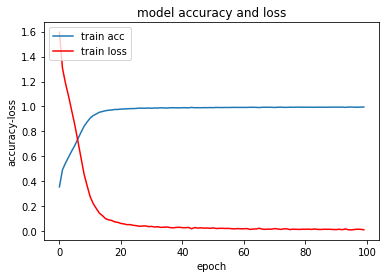

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'],'r')
plt.title('model accuracy and loss')
plt.ylabel('accuracy-loss')
plt.xlabel('epoch')
plt.legend(['train acc','train loss'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


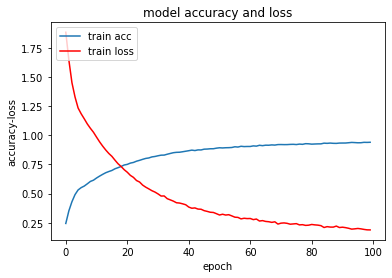

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'],'r')
plt.title('model accuracy and loss')
plt.ylabel('accuracy-loss')
plt.xlabel('epoch')
plt.legend(['train acc','train loss'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


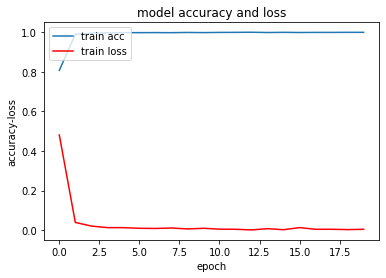

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(my_history.history.keys())
# summarize history for accuracy
plt.plot(my_history.history['accuracy'])
plt.plot(my_history.history['loss'],'r')
plt.title('model accuracy and loss')
plt.ylabel('accuracy-loss')
plt.xlabel('epoch')
plt.legend(['train acc','train loss'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


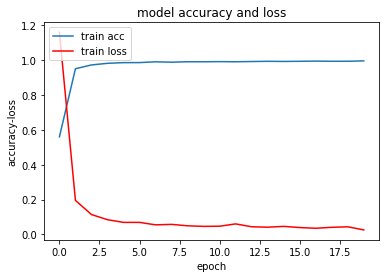

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(my_history1.history.keys())
# summarize history for accuracy
plt.plot(my_history1.history['accuracy'])
plt.plot(my_history1.history['loss'],'r')
plt.title('model accuracy and loss')
plt.ylabel('accuracy-loss')
plt.xlabel('epoch')
plt.legend(['train acc','train loss'], loc='upper left')
plt.show()

In [ ]:
y_pred_probs = vgg_model.predict(fer_x_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = fer_y_test.argmax(axis=1)

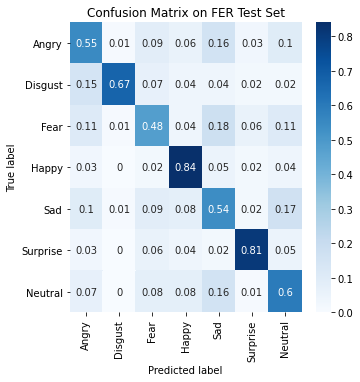

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred_probs = my_model.predict(fer_x_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = fer_y_test.argmax(axis=1)

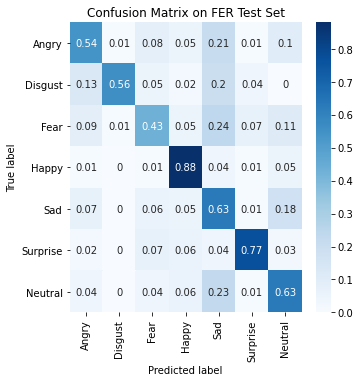

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred_probs = ensemble_model.predict(fer_x_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = fer_y_test.argmax(axis=1)

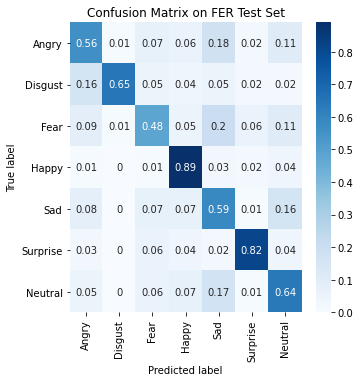

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def get_datagen(dataset):
    return ImageDataGenerator().flow_from_directory(
              dataset,
              target_size=(48,48),
              color_mode='rgb',
              shuffle = True,
              class_mode='categorical',
              batch_size=32)

In [ ]:
from skimage import io, transform

X_test_gen    = get_datagen('/content/animated_test')

X_test = np.zeros((len(X_test_gen.filepaths), 48, 48, 3))
Y_test = np.zeros((len(X_test_gen.filepaths), 7))
for i in range(0,len(X_test_gen.filepaths)):
  x = io.imread(X_test_gen.filepaths[i], as_gray=True)
  X_test[i,:] = transform.resize(x, (48,48,3))
  Y_test[i,X_test_gen.classes[i]] = 1

Found 8661 images belonging to 7 classes.


In [ ]:
y_pred_probs = vgg_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

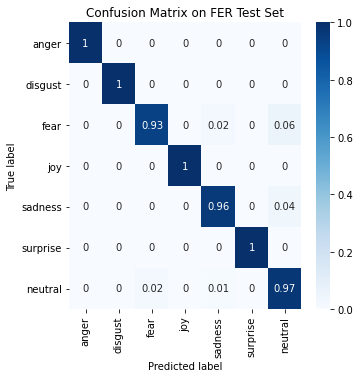

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

animate_emotions={0:'anger',1:'disgust',2:'fear',3:'joy',4:'sadness',5:'surprise',6:'neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=animate_emotions.values(), 
  columns=animate_emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred_probs = my_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

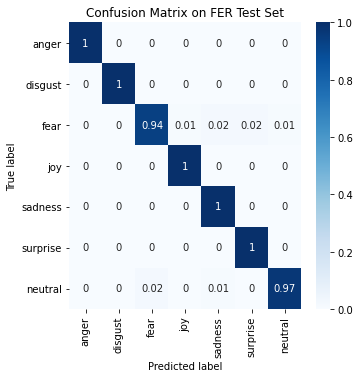

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

animate_emotions={0:'anger',1:'disgust',2:'fear',3:'joy',4:'sadness',5:'surprise',6:'neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=animate_emotions.values(), 
  columns=animate_emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred_probs = ensemble_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

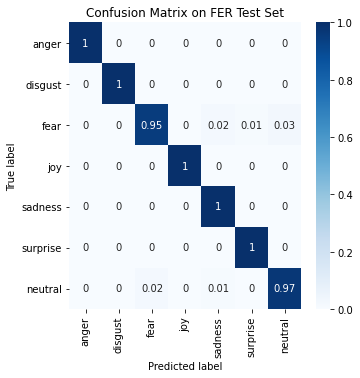

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

animate_emotions={0:'anger',1:'disgust',2:'fear',3:'joy',4:'sadness',5:'surprise',6:'neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=animate_emotions.values(), 
  columns=animate_emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on FER Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()